In [2]:
import json
import pandas as pd
from scipy.stats import mannwhitneyu
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import os.path
from pymrmr import mRMR
import matplotlib.pyplot as plt
from boruta import BorutaPy
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import pandas as pd

/home/ale/.local/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version. The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


# Import raw data

In [3]:
# import data from csv 
cnv = pd.read_csv('dataset_hg19/dataset/cnv.csv', sep=' ')
miRNA = pd.read_csv('dataset_hg19/dataset/mirna.csv', sep=' ')
mRNA = pd.read_csv('dataset_hg19/dataset/mrna.csv', sep=' ')
proteins = pd.read_csv('dataset_hg19/dataset/proteins.csv', sep=' ')

In [4]:
label = pd.read_csv('dataset_hg19/dataset/labels_pfi.csv', sep=' ')

In [5]:
def store_filtered_normalize_data(dataset_dict):
    mkdir_p('filtered_normalize_data')
    filtered_normalize_data = create_data_normalized_filtered(dataset_dict, MinMaxScaler, 0.05)
    for data in dataset_dict:
        filtered_normalize_data[data].to_json('filtered_normalize_data/'+data+'.json')

In [6]:
def load_filtered_normalize_data(dataset_dict):
    dict_test = {}
    if os.path.exists('filtered_normalize_data'):
        for data in dataset_dict:
            with open('filtered_normalize_data/'+data+'.json', 'r') as fp:
                dataset = pd.read_json(fp)
                dict_test[data] = dataset
        return dict_test
    else:
        store_filtered_normalize_data(dataset_dict)
        load_filtered_normalize_data(dataset_dict)

In [14]:
dataset_dict = {'cnv': cnv, 'mirna': miRNA, 'mrna': mRNA, 'proteins': proteins}

datasets = load_filtered_normalize_data(dataset_dict)

# Create concatenation of all dataset

In [15]:
dataset_whole_dataset = pd.concat([datasets['cnv'], datasets['proteins'], datasets['mrna'], datasets['mirna']], axis=1)

In [16]:
datasets['whole_dataset'] = dataset_whole_dataset

# Create concatenation of dataset: proteins+mirna, proteins+mirna+mrna

In [17]:
proteins_mirna_dataset = pd.concat([datasets['proteins'], datasets['mirna']], axis=1)
datasets['proteins_mirna_dataset'] = proteins_mirna_dataset

In [18]:
proteins_mirna_mrna_dataset = pd.concat([datasets['proteins'], datasets['mirna'], datasets['mrna']], axis=1)
datasets['proteins_mirna_mrna_dataset'] = proteins_mirna_mrna_dataset

# Remove correlated feature using R code

In [19]:
robjects.r("""
install.packages('caret')
""")

R[write to console]: Installazione pacchetto in ‘/usr/local/lib/R/site-library’
(perché ‘lib’ non è specificato)

R[write to console]: apertura URL 'https://cloud.r-project.org/src/contrib/caret_6.0-93.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2273775 bytes (2.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

gcc -I"/usr/share/R/include" -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-Faorqz/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c caret.c -o caret.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o caret.so caret.o -L/usr/lib/R/lib -lR


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (caret)
R[write to console]: 

R[write to console]: 
R[write to console]: I pacchetti scaricati con il codice sorgente sono in
	‘/tmp/RtmpQezON7/downloaded_packages’
R[write to console]: 
R[write to console]: 



<rpy2.rinterface.NULLType object at 0x7f11b75e14c0> [RTYPES.NILSXP]

In [20]:
robjects.r("""
library(doParallel)
""")

R[write to console]: Caricamento del pacchetto richiesto: foreach

R[write to console]: Caricamento del pacchetto richiesto: iterators

R[write to console]: Caricamento del pacchetto richiesto: parallel



'doParall...,'parallel','iterators',...,'datasets','methods','base'


In [21]:
robjects.r("""
remove_correlated_par <- function(df, dim_split = 1000, maxiter = 5, method = "pearson", cutoff = 0.8){
  
  #df has features on columns
  X = t(df)
  niter = 0
  if (!is.finite(dim_split)) dim_split = nrow(X)
  cat("dim(X) before starting remove correlation: ", dim(X), "\n")
  while(niter < maxiter ){
    cat("niter = ", niter, '\n')
    filtered_X = NULL
    
    cl <- makeCluster(4)
    registerDoParallel(cl)
    
    filtered_X = foreach(nR = seq(1, nrow(X), by=dim_split), 
                         .combine='rbind', .packages = c("caret")) %dopar% {
                           
         subX = X[nR:min(nrow(X), (nR+dim_split-1)), ]
         cc = cor(t(subX), use = "pairwise.complete.obs", method = "kendall")
         
         select_corr = caret::findCorrelation(cc, cutoff = cutoff, exact = FALSE)
         #print(length(select_corr))
         
         if (length(select_corr)>0){ 
           subX = subX[-select_corr, ]
         }
         
         return(subX)
           
     }
    
    stopCluster(cl)
    
    print(names(filtered_X))
    #    if (length(unique(filtered_X[,1]))>1) cat('PROBLEMA!')
    no_removed = nrow(X)-nrow(filtered_X)
    cat('Removed = ', no_removed, '\n')
    cat('dim filetered_X =', dim(filtered_X), '\n')

    X = filtered_X[sample(nrow(filtered_X)), ]
    
    niter = niter + 1
    cat("nrow(X) =", dim(X), '\n')
    if (no_removed ==0) break;
  }
  cat('final dimension = ', dim(t(X)), '\n')
  
  
  return(t(X))
    }
    """)

R object with classes: ('function',) mapped to:

# Convert data in a r structure data

In [22]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins = robjects.conversion.py2rpy(datasets['proteins'])

/home/ale/.local/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:53: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [14]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_miRNA = robjects.conversion.py2rpy(datasets['miRNA'])

In [15]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_mRNA = robjects.conversion.py2rpy(datasets['mRNA'])

In [16]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_cnv = robjects.conversion.py2rpy(datasets['cnv'])

In [17]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_whole_dataset = robjects.conversion.py2rpy(datasets['whole_dataset'])

In [ ]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins_mirna_dataset = robjects.conversion.py2rpy(datasets['proteins_mirna_dataset'])

In [ ]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins_mirna_mrna_dataset = robjects.conversion.py2rpy(datasets['proteins_mirna_mrna_dataset'])

# Store data in local

In [23]:
def compute_and_save_result(data, path):
    data_removed = robjects.globalenv["remove_correlated_par"](data)
    df = pd.DataFrame(data=np.array(data_removed), columns=data_removed.colnames)
    df.to_json(path)
    
def restore_result(file_name):
    return pd.read_json(f'elaborated_data_with_r_function/{file_name}.json')

def load_or_store_removed_correlated(data, file_name):
    if os.path.exists(f'elaborated_data_with_r_function/{file_name}.json'):
        return restore_result(file_name)
    else:
        compute_and_save_result(data, f'elaborated_data_with_r_function/{file_name}.json')
        return restore_result(file_name)

In [24]:
df_proteins_removed = load_or_store_removed_correlated(r_proteins, 'r_proteins_removed')

In [20]:
df_mirna_removed = load_or_store_removed_correlated(r_miRNA, 'r_mirna_removed')

In [21]:
df_mrna_removed = load_or_store_removed_correlated(r_mRNA, 'r_mrna_removed')

In [22]:
df_cnv_removed = load_or_store_removed_correlated(r_cnv, 'r_cnv_removed')

In [23]:
df_dataset_whole_dataset_removed = load_or_store_removed_correlated(r_whole_dataset, 'r_dataset_whole_dataset_removed')

In [ ]:
df_dataset_proteins_mirna_removed = load_or_store_removed_correlated(r_proteins_mirna_dataset, 'r_dataset_proteins_mirna_removed')

In [ ]:
df_dataset_proteins_mirna_mrna_removed = load_or_store_removed_correlated(r_proteins_mirna_mrna_dataset, 'r_dataset_proteins_mirna_mrna_removed')

In [24]:
print('DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE')

DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE


# Mann-Whitney

In [8]:
def create_dataframe_pos_neg(dataset, label):
    mask_1 = label['x']==1
    mask_0 = label['x']==0
    return (dataset[mask_1.values], dataset[mask_0.values])

In [9]:
def mann_whitney_features_selection(dataset, label, min_pValue):
    pos, neg = create_dataframe_pos_neg(dataset, label)
    H, pval = mannwhitneyu(pos, neg)
    mask = (pval < min_pValue)
    return dataset.columns[mask]

# Multivariate feature selection, mrmr and Boruta 

In [10]:
def execute_mrmr(dataset, n_feature):
    return mRMR(dataset, 'MIQ', n_feature)

In [11]:
def execute_boruta_feature_selection(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    holdout_number: int,
    max_iter: int = 100,
):
    """Returns tuple with list of kept features and list of discared features.
    
    Parameters
    --------------------------
    X_train: pd.DataFrame,
        The data reserved for the input of the training of the Boruta model.
    y_train: np.ndarray,
        The data reserved for the output of the training of the Boruta model.
    holdout_number: int,
        The current holdout number.
    max_iter: int = 100,
        Number of iterations to run Boruta for.
    """

    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5)
    
    boruta_selector = BorutaPy(
        model,
        n_estimators='auto',
        verbose=False,
        alpha=0.05,
        max_iter=max_iter, 
        random_state=42,
    )
    boruta_selector.fit(X_train.values, y_train.values.ravel())
    
    kept_features = list(X_train.columns[boruta_selector.support_])
    discarded_features = list(X_train.columns[~boruta_selector.support_])
    
    return kept_features, discarded_features

# Train on fold

In [29]:
def train_using_mann_whitney(X,
                            label, 
                            num_external_fold,
                            type_dataset, 
                            tecnique_feature_selection,
                            path):
    
    aucs = []
    y_score_concatenated = []
    y_test_fold_concatenated = []
    list_selected_feature = {}
    iteration = 0
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {} 
    
   
    X_numpy = X.values
    label_numpy = label['x'].values
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        df_X_train = pd.DataFrame(data=X_train_fold, columns=X.columns)
        df_X_test = pd.DataFrame(data=X_test_fold, columns=X.columns)
        df_y_train = pd.DataFrame(data=y_train_fold, columns=label.columns)
        
        selected_features = mann_whitney_features_selection(df_X_train, df_y_train, 0.05)
        
        iteration = iteration + 1
        list_selected_feature[iteration] = selected_features
        
        X_train_selected_feature = df_X_train[selected_features]
        X_test_selected_feature = df_X_test[selected_features]
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_selected_feature, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_selected_feature)[:, 1]
        
        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_score)

        #plot_precision_recall_curve(classifier, X_test_selected_feature, y_test_fold)
        
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        
        aucs.append(auc_precision_recall)
        #print('auc: {:.3f} using params {}:'.format(auc_precision_recall, clf.best_params_))
    
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score)
        plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+str(iterator)+'_AUPRC_Internal.pdf')
    
    internal_auc = np.mean(aucs)
    
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test_fold_concatenated, y_score_concatenated)
    
    external_auc = auc(recall, precision)
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated)
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_auc)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_auc)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    result_dict[type_dataset][tecnique_feature_selection]['feature_used'] = str(list_selected_feature)
    
    plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open(path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    #plt.show()    
    
    return list_selected_feature

# GridSearch

In [12]:
model_selection_grid_DT = [
    {'criterion': ['gini', 'entropy'],
     'max_leaf_nodes': [None, 2, 5, 10],
     'max_features': [None, 'sqrt', 'log2'],
    'n_estimators': [51, 101, 251, 500]}
]

# Train using multivariate feature selection after mannwhitney on fold

In [35]:
def train_using_multivariate(X,
                             label,
                             list_selected_feature_from_mannwhiney, 
                             num_external_fold,
                             tecnique_feature_selection,
                             path,
                             type_dataset,
                             type_feature_selection=None):
    
    aucs = []
    iteration = 0
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    list_selected_feature = {}
    iteration = 0
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {} 
    
    X_numpy = X.values
    label_numpy = label['x'].values
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for (train_index, test_index), selected_features in zip(tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False), list_selected_feature_from_mannwhiney.values()):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        df_X_train = pd.DataFrame(data=X_train_fold, columns=X.columns)
        df_X_test = pd.DataFrame(data=X_test_fold, columns=X.columns)
        df_y_train = pd.DataFrame(data=y_train_fold, columns=label.columns)
        
        #TAKE FEATURES FROM MANNWHINEY
        X_train_selected_feature = df_X_train[selected_features]
        X_test_selected_feature = df_X_test[selected_features]
        
        print(f'TRAIN:{X_train_selected_feature}')
        print('*'*10)
       
        if type_feature_selection == "mrmr":
            selected_features = execute_mrmr(X_train_selected_feature, 100)
        elif type_feature_selection == 'boruta':
            selected_features, discarded_feature =  execute_boruta_feature_selection(X_train_selected_feature, df_y_train, 5)
        
        iteration = iteration + 1
        list_selected_feature[iteration] = selected_features
        
        
        X_train_selected_feature = X_train_selected_feature[selected_features]
        X_test_selected_feature = X_test_selected_feature[selected_features]
        
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_selected_feature, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_selected_feature)[:, 1]
        
        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_score)

        #plot_precision_recall_curve(classifier, X_test_selected_feature, y_test_fold)
        
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        
        aucs.append(auc_precision_recall)
        #print('auc: {:.3f} using params {}:'.format(auc_precision_recall, clf.best_params_))
    
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score)
        plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+str(iterator)+'_AUPRC_Internal.pdf')
        
    internal_auc = np.mean(aucs)
    
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test_fold_concatenated, y_score_concatenated)
    
    external_auc = auc(recall, precision)
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated)
    #plt.show()
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_auc)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_auc)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    result_dict[type_dataset][tecnique_feature_selection]['feature_used'] = str(list_selected_feature)
    
    plt.savefig(path+tecnique_feature_selection+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open(path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return list_selected_feature

# Train proteins

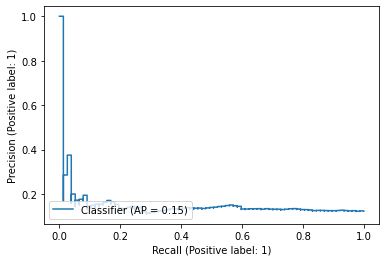

In [36]:
list_selected_feature_proteins = train_using_mann_whitney(df_proteins_removed, label, 10, 'proteins', 'r_function_with_mannwhitney', 'result_new_experiment/')

In [ ]:
train_using_multivariate(df_proteins_removed, label, list_selected_feature_proteins, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'proteins',
                         'mrmr')

Running fold : 0it [00:00, ?it/s]

TRAIN:         DJ-1  PRAS40_pT246  PI3K-p110-alpha    Raptor      mTOR       Bak  \
0    0.185574      0.617066         0.359405  0.529149  0.492546  0.271351   
1    0.387452      0.495525         0.578251  0.585857  0.719286  0.188512   
2    0.306858      0.477525         0.659427  0.686111  0.726308  0.277083   
3    0.390525      0.619577         0.629609  0.473294  0.696904  0.112355   
4    0.275742      0.436008         0.564432  0.529218  0.732141  0.218472   
..        ...           ...              ...       ...       ...       ...   
559  0.291518      0.390538         0.635518  0.447710  0.691732  0.224603   
560  0.333785      0.598971         0.158252  0.467071  0.292064  0.435139   
561  0.320192      0.358247         0.742245  0.667221  0.786068  0.318863   
562  0.420811      0.425565         0.686700  0.455318  0.653618  0.212548   
563  0.423565      0.453955         0.640973  0.633603  0.718558  0.332094   

     Fibronectin  Annexin_VII       p27      Jak2     PRE

Running fold : 1it [00:09,  9.67s/it]

TRAIN:         DJ-1  PRAS40_pT246  mTOR_pS2448    Raptor       TAZ      mTOR  \
0    0.185574      0.617066     0.532247  0.529149  0.338049  0.492546   
1    0.387452      0.495525     0.540128  0.585857  0.498288  0.719286   
2    0.390525      0.619577     0.618668  0.473294  0.122691  0.696904   
3    0.275742      0.436008     0.619638  0.529218  0.327201  0.732141   
4    0.356126      0.544994     0.544668  0.660301  0.379101  0.657509   
..        ...           ...          ...       ...       ...       ...   
559  0.335768      0.467791     0.680331  0.565195  0.106022  0.731842   
560  0.291518      0.390538     0.637327  0.447710  0.239641  0.691732   
561  0.333785      0.598971     0.556632  0.467071  0.864135  0.292064   
562  0.420811      0.425565     0.616971  0.455318  0.155781  0.653618   
563  0.220022      0.576911     0.663278  0.580821  0.116415  0.750879   

       INPP4B      FASN     A-Raf     eIF4E       p27      Jak2     PREX1  \
0    0.404724  0.535370  0.5

Running fold : 2it [00:20, 10.22s/it]

TRAIN:     PRAS40_pT246  GSK3_pS9    Raptor  Bap1-c-4      mTOR  Akt_pT308  \
0        0.495525  0.672550  0.585857  0.681708  0.719286   0.132333   
1        0.477525  0.697664  0.686111  0.728234  0.726308   0.171672   
2        0.619577  0.743051  0.473294  0.683408  0.696904   0.351156   
3        0.544994  0.679892  0.660301  0.492446  0.657509   0.283333   
4        0.568934  0.722482  0.830716  0.522236  0.728155   0.155038   
..            ...       ...       ...       ...       ...        ...   
559      0.481865  0.660544  0.487904  0.862527  0.648199   0.132944   
560      0.358247  0.725609  0.667221  0.887835  0.786068   0.102826   
561      0.425565  0.756008  0.455318  0.694129  0.653618   0.171533   
562      0.453955  0.804405  0.633603  0.562741  0.718558   0.282246   
563      0.576911  0.865275  0.580821  0.831810  0.750879   0.482068   

         FASN  E-Cadherin     eIF4E       p27      Jak2     PREX1  Shc_pY317  \
0    0.583959    0.838642  0.588479  0.442895  0.

Running fold : 3it [00:29,  9.75s/it]

TRAIN:     PRAS40_pT246  MAPK_pT202_Y204  GSK3_pS9    Raptor  beta-Catenin  \
0        0.617066         0.443176  0.686583  0.529149      0.523645   
1        0.495525         0.162967  0.672550  0.585857      0.691574   
2        0.477525         0.514868  0.697664  0.686111      0.586991   
3        0.619577         0.552509  0.743051  0.473294      0.484858   
4        0.436008         0.331835  0.410635  0.529218      0.702026   
..            ...              ...       ...       ...           ...   
559      0.598971         0.256692  0.624226  0.467071      0.360143   
560      0.358247         0.631161  0.725609  0.667221      0.740558   
561      0.425565         0.441441  0.756008  0.455318      0.470123   
562      0.453955         0.654569  0.804405  0.633603      0.445380   
563      0.576911         0.446672  0.865275  0.580821      0.492703   

         mTOR  S6_pS240_S244  Akt_pT308  JNK_pT183_pY185     A-Raf  ...  \
0    0.492546       0.476297   0.162834         0.3151

Running fold : 4it [00:40, 10.34s/it]

TRAIN:         DJ-1  PRAS40_pT246    Raptor  Bap1-c-4      mTOR     eIF4E       p27  \
0    0.185574      0.617066  0.529149  0.559667  0.492546  0.333098  0.218901   
1    0.387452      0.495525  0.585857  0.681708  0.719286  0.588479  0.442895   
2    0.306858      0.477525  0.686111  0.728234  0.726308  0.448134  0.288495   
3    0.390525      0.619577  0.473294  0.683408  0.696904  0.517655  0.416031   
4    0.275742      0.436008  0.529218  0.896530  0.732141  0.631026  0.193335   
..        ...           ...       ...       ...       ...       ...       ...   
559  0.291518      0.390538  0.447710  0.818467  0.691732  0.601884  0.162086   
560  0.333785      0.598971  0.467071  0.792183  0.292064  0.224828  0.489697   
561  0.320192      0.358247  0.667221  0.887835  0.786068  0.563020  0.433030   
562  0.423565      0.453955  0.633603  0.562741  0.718558  0.599967  0.200432   
563  0.220022      0.576911  0.580821  0.831810  0.750879  0.475355  0.234414   

         Jak2  Shc_pY

Running fold : 5it [00:50, 10.06s/it]

TRAIN:     PRAS40_pT246  MAPK_pT202_Y204  GSK3_pS9    Raptor      FASN  \
0        0.617066         0.443176  0.686583  0.529149  0.535370   
1        0.477525         0.514868  0.697664  0.686111  0.565189   
2        0.619577         0.552509  0.743051  0.473294  0.457468   
3        0.436008         0.331835  0.410635  0.529218  0.436260   
4        0.544994         0.528907  0.679892  0.660301  0.368028   
..            ...              ...       ...       ...       ...   
559      0.598971         0.256692  0.624226  0.467071  0.308092   
560      0.358247         0.631161  0.725609  0.667221  0.291593   
561      0.425565         0.441441  0.756008  0.455318  0.610368   
562      0.453955         0.654569  0.804405  0.633603  0.309929   
563      0.576911         0.446672  0.865275  0.580821  0.525620   

     JNK_pT183_pY185     eIF4E       p27      Jak2  p38_pT180_Y182  Akt_pS473  \
0           0.315199  0.333098  0.218901  0.661667        0.562600   0.219820   
1           0.3

Running fold : 6it [01:00,  9.96s/it]

TRAIN:     PRAS40_pT246  GSK3_pS9    Raptor      mTOR     eIF4E       p27  \
0        0.617066  0.686583  0.529149  0.492546  0.333098  0.218901   
1        0.495525  0.672550  0.585857  0.719286  0.588479  0.442895   
2        0.477525  0.697664  0.686111  0.726308  0.448134  0.288495   
3        0.619577  0.743051  0.473294  0.696904  0.517655  0.416031   
4        0.436008  0.410635  0.529218  0.732141  0.631026  0.193335   
..            ...       ...       ...       ...       ...       ...   
559      0.598971  0.624226  0.467071  0.292064  0.224828  0.489697   
560      0.358247  0.725609  0.667221  0.786068  0.563020  0.433030   
561      0.425565  0.756008  0.455318  0.653618  0.649475  0.274580   
562      0.453955  0.804405  0.633603  0.718558  0.599967  0.200432   
563      0.576911  0.865275  0.580821  0.750879  0.475355  0.234414   

     Cyclin_B1      Jak2     PREX1      ERK2     XRCC1  MEK1_pS217_S221  \
0     0.536106  0.661667  0.287046  0.777928  0.535748         0.2

Running fold : 7it [01:08,  9.60s/it]

TRAIN:     PRAS40_pT246    Raptor       TAZ      mTOR       Bak      FASN       p27  \
0        0.617066  0.529149  0.338049  0.492546  0.271351  0.535370  0.218901   
1        0.495525  0.585857  0.498288  0.719286  0.188512  0.583959  0.442895   
2        0.477525  0.686111  0.248513  0.726308  0.277083  0.565189  0.288495   
3        0.436008  0.529218  0.327201  0.732141  0.218472  0.436260  0.193335   
4        0.544994  0.660301  0.379101  0.657509  0.298062  0.368028  0.350269   
..            ...       ...       ...       ...       ...       ...       ...   
560      0.598971  0.467071  0.864135  0.292064  0.435139  0.308092  0.489697   
561      0.358247  0.667221  0.218656  0.786068  0.318863  0.291593  0.433030   
562      0.425565  0.455318  0.155781  0.653618  0.212548  0.610368  0.274580   
563      0.453955  0.633603  0.313925  0.718558  0.332094  0.309929  0.200432   
564      0.576911  0.580821  0.116415  0.750879  0.354618  0.525620  0.234414   

         Jak2     PRE

Running fold : 8it [01:17,  9.42s/it]

TRAIN:     PRAS40_pT246  PI3K-p110-alpha    Raptor      mTOR       Bak     A-Raf  \
0        0.617066         0.359405  0.529149  0.492546  0.271351  0.597189   
1        0.495525         0.578251  0.585857  0.719286  0.188512  0.692356   
2        0.477525         0.659427  0.686111  0.726308  0.277083  0.677520   
3        0.619577         0.629609  0.473294  0.696904  0.112355  0.701265   
4        0.436008         0.564432  0.529218  0.732141  0.218472  0.668388   
..            ...              ...       ...       ...       ...       ...   
560      0.598971         0.158252  0.467071  0.292064  0.435139  0.131184   
561      0.358247         0.742245  0.667221  0.786068  0.318863  0.660413   
562      0.425565         0.686700  0.455318  0.653618  0.212548  0.608169   
563      0.453955         0.640973  0.633603  0.718558  0.332094  0.706199   
564      0.576911         0.606256  0.580821  0.750879  0.354618  0.650329   

        eIF4E       p27      Jak2     PREX1  Shc_pY317   

Running fold : 9it [01:27,  9.55s/it]

TRAIN:     PRAS40_pT246    Raptor       TAZ  beta-Catenin      mTOR      FASN  \
0        0.617066  0.529149  0.338049      0.523645  0.492546  0.535370   
1        0.495525  0.585857  0.498288      0.691574  0.719286  0.583959   
2        0.477525  0.686111  0.248513      0.586991  0.726308  0.565189   
3        0.619577  0.473294  0.122691      0.484858  0.696904  0.457468   
4        0.436008  0.529218  0.327201      0.702026  0.732141  0.436260   
..            ...       ...       ...           ...       ...       ...   
560      0.598971  0.467071  0.864135      0.360143  0.292064  0.308092   
561      0.358247  0.667221  0.218656      0.740558  0.786068  0.291593   
562      0.425565  0.455318  0.155781      0.470123  0.653618  0.610368   
563      0.453955  0.633603  0.313925      0.445380  0.718558  0.309929   
564      0.576911  0.580821  0.116415      0.492703  0.750879  0.525620   

     JNK_pT183_pY185     A-Raf       p27      Jak2  Shc_pY317  p38_pT180_Y182  \
0           

{1: ['PRAS40_pT246', 'PI3K-p110-alpha', 'Annexin_VII', 'p27', 'Shc_pY317'],
 2: ['PRAS40_pT246', 'mTOR_pS2448', 'mTOR', 'p27', 'XRCC1', '4E-BP1_pS65'],
 3: ['mTOR', 'p27', 'MIG-6'],
 4: ['PRAS40_pT246', 'mTOR', 'p27', 'Jak2', 'Ku80'],
 5: ['PRAS40_pT246', 'eIF4E', 'p27', 'Jak2', 'Shc_pY317', 'XRCC1'],
 6: ['PRAS40_pT246', 'GSK3_pS9', 'p27'],
 7: ['mTOR', 'eIF4E', 'p27'],
 8: ['PRAS40_pT246', 'mTOR', 'p27', 'B-Raf_pS445'],
 9: ['mTOR', 'p27', 'Jak2', 'PREX1', 'Shc_pY317'],
 10: ['PRAS40_pT246', 'mTOR', 'Jak2', 'Shc_pY317']}

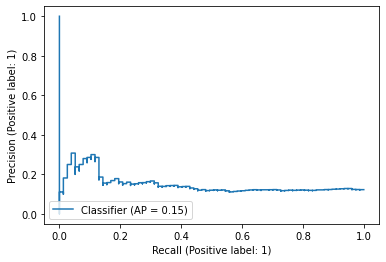

In [37]:
train_using_multivariate(df_proteins_removed, label, list_selected_feature_proteins, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'proteins',
                         'boruta')

# Train miRNA 

In [ ]:
list_selected_feature_mirna = train_using_mann_whitney(df_mirna_removed, label, 10, 'mirna', 'r_function_with_mannwhitney', 'result_new_experiment/')

In [ ]:
train_using_multivariate(df_mirna_removed, label, list_selected_feature_mirna, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'miRNA',
                         'mrmr')

In [ ]:
train_using_multivariate(df_mirna_removed, label, list_selected_feature_mirna, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'miRNA',
                         'boruta')

# Train mrna

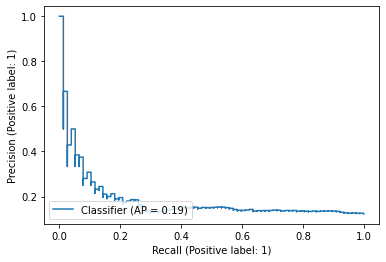

In [33]:
list_selected_feature_mrna = train_using_mann_whitney(df_mrna_removed, label, 10, 'mRNA', 'r_function_with_mannwhitney', 'result_new_experiment/')

Running fold : 0it [00:00, ?it/s]

TRAIN:      ANKRD29    FBXO22     RBM4B      CLK4     ITGB7    DBNDD2      DVL2  \
0    0.006367  0.067629  0.106883  0.082949  0.089540  0.023538  0.180624   
1    0.024558  0.110473  0.174465  0.100092  0.078159  0.076410  0.235056   
2    0.007926  0.040446  0.108131  0.202949  0.027615  0.058200  0.163586   
3    0.007926  0.042240  0.039717  0.055668  0.061590  0.053340  0.100347   
4    0.002599  0.118404  0.070909  0.091797  0.067448  0.224799  0.232313   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.000000  0.065256  0.093575  0.000000  0.011883  0.004728  0.053711   
560  0.043919  0.071946  0.200457  0.389862  0.038661  0.122998  0.142795   
561  0.007796  0.000000  0.045124  0.012903  0.110795  0.109354  0.045048   
562  0.032614  0.112289  0.106467  0.265622  0.150293  0.108596  0.193763   
563  0.012734  0.045110  0.100853  0.148018  0.045021  0.084358  0.151314   

     C17orf44       UNK     ISG20  ...      TBCB      CUX1  LOC100128

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 1it [1:05:00, 3900.36s/it]

TRAIN:        RBM4B      CLK4     ITGB7  C16orf53    DBNDD2      DVL2       UNK  \
0    0.106883  0.082949  0.089540  0.120605  0.023538  0.180624  0.335732   
1    0.174465  0.100092  0.078159  0.199623  0.076410  0.235056  0.548342   
2    0.039717  0.055668  0.061590  0.032867  0.053340  0.100347  0.080413   
3    0.070909  0.091797  0.067448  0.123599  0.224799  0.232313  0.253285   
4    0.110834  0.098065  0.056736  0.252301  0.127227  0.112763  0.198373   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.195883  0.113364  0.048703  0.322070  0.168399  0.087208  0.282697   
560  0.093575  0.000000  0.011883  0.033199  0.004728  0.053711  0.033949   
561  0.200457  0.389862  0.038661  0.168438  0.122998  0.142795  0.224656   
562  0.106467  0.265622  0.150293  0.071182  0.108596  0.193763  0.278630   
563  0.323560  0.159816  0.040502  0.545893  0.245960  0.251949  0.385795   

      BLOC1S1      SARS      WBP1  ...      GLUL      BBS2      TBCB 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 2it [2:20:24, 4267.40s/it]

TRAIN:        RBM4B    DBNDD2      DVL2     QTRT1       UNK     ISG20   SLC27A4  \
0    0.174465  0.076410  0.235056  0.238110  0.548342  0.069687  0.300315   
1    0.108131  0.058200  0.163586  0.424109  0.299124  0.024030  0.211333   
2    0.039717  0.053340  0.100347  0.111599  0.080413  0.085173  0.034945   
3    0.110834  0.127227  0.112763  0.223356  0.198373  0.064525  0.195481   
4    0.143897  0.197591  0.154346  0.174227  0.092929  0.027679  0.124015   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.100853  0.518244  0.116517  0.275310  0.368899  0.294589  0.080750   
560  0.045124  0.109354  0.045048  0.348140  0.112484  0.284888  0.111315   
561  0.106467  0.108596  0.193763  0.266677  0.278630  0.072802  0.119373   
562  0.100853  0.084358  0.151314  0.318160  0.108730  0.041919  0.114556   
563  0.323560  0.245960  0.251949  0.278606  0.385795  0.047615  0.431862   

         SARS      WBP1    PIWIL3  ...    COMMD4    STXBP2      BBS2 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 3it [3:00:14, 3409.96s/it]

TRAIN:      ATXN7L2     RBM4B      CLK4     ITGB7    DBNDD2      DVL2  C17orf44  \
0    0.072150  0.106883  0.082949  0.089540  0.023538  0.180624  0.022653   
1    0.183261  0.174465  0.100092  0.078159  0.076410  0.235056  0.017537   
2    0.102453  0.108131  0.202949  0.027615  0.058200  0.163586  0.037998   
3    0.065416  0.039717  0.055668  0.061590  0.053340  0.100347  0.051151   
4    0.057720  0.070909  0.091797  0.067448  0.224799  0.232313  0.089879   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.167388  0.200457  0.389862  0.038661  0.122998  0.142795  0.058093   
560  0.175084  0.045124  0.012903  0.110795  0.109354  0.045048  0.042748   
561  0.113035  0.106467  0.265622  0.150293  0.108596  0.193763  0.067592   
562  0.092833  0.100853  0.148018  0.045021  0.084358  0.151314  0.077822   
563  0.208273  0.323560  0.159816  0.040502  0.245960  0.251949  0.017537   

          UNK     ISG20      SARS  ...    STXBP2      BBS2   FAM184A 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 4it [4:04:24, 3583.68s/it]

TRAIN:        RBM4B    DBNDD2      DVL2     CASC5       UNK     ISG20      SARS  \
0    0.106883  0.023538  0.180624  0.024818  0.335732  0.085440  0.047161   
1    0.174465  0.076410  0.235056  0.027939  0.548342  0.069687  0.184424   
2    0.108131  0.058200  0.163586  0.031208  0.299124  0.024030  0.214927   
3    0.039717  0.053340  0.100347  0.007579  0.080413  0.085173  0.069010   
4    0.070909  0.224799  0.232313  0.022143  0.253285  0.269313  0.184208   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.093575  0.004728  0.053711  0.020954  0.033949  0.119171  0.117217   
560  0.200457  0.122998  0.142795  0.001635  0.224656  0.042542  0.158752   
561  0.045124  0.109354  0.045048  0.000297  0.112484  0.284888  0.351037   
562  0.100853  0.084358  0.151314  0.001040  0.108730  0.041919  0.174725   
563  0.323560  0.245960  0.251949  0.124981  0.385795  0.047615  0.381756   

       PIWIL3    CCDC22      CD24  ...    ADRBK1  ANKRD13D  LOC100129

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 5it [4:20:01, 2629.34s/it]

TRAIN:        RBM4B     ITGB7    DBNDD2      DVL2     QTRT1     CASC5       UNK  \
0    0.106883  0.089540  0.023538  0.180624  0.126825  0.024818  0.335732   
1    0.108131  0.027615  0.058200  0.163586  0.424109  0.031208  0.299124   
2    0.039717  0.061590  0.053340  0.100347  0.111599  0.007579  0.080413   
3    0.070909  0.067448  0.224799  0.232313  0.278763  0.022143  0.253285   
4    0.110834  0.056736  0.127227  0.112763  0.223356  0.018725  0.198373   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.200457  0.038661  0.122998  0.142795  0.508240  0.001635  0.224656   
560  0.045124  0.110795  0.109354  0.045048  0.348140  0.000297  0.112484   
561  0.106467  0.150293  0.108596  0.193763  0.266677  0.042948  0.278630   
562  0.100853  0.045021  0.084358  0.151314  0.318160  0.001040  0.108730   
563  0.323560  0.040502  0.245960  0.251949  0.278606  0.124981  0.385795   

        ISG20      SARS      WBP1  ...  C1orf128     HCG26    COMMD4 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 6it [4:50:16, 2352.55s/it]

TRAIN:        RBM4B     ITGB7    DBNDD2      DVL2  C17orf44     QTRT1       UNK  \
0    0.106883  0.089540  0.023538  0.180624  0.022653  0.126825  0.335732   
1    0.174465  0.078159  0.076410  0.235056  0.017537  0.238110  0.548342   
2    0.108131  0.027615  0.058200  0.163586  0.037998  0.424109  0.299124   
3    0.039717  0.061590  0.053340  0.100347  0.051151  0.111599  0.080413   
4    0.070909  0.067448  0.224799  0.232313  0.089879  0.278763  0.253285   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.200457  0.038661  0.122998  0.142795  0.058093  0.508240  0.224656   
560  0.045124  0.110795  0.109354  0.045048  0.042748  0.348140  0.112484   
561  0.106467  0.150293  0.108596  0.193763  0.067592  0.266677  0.278630   
562  0.100853  0.045021  0.084358  0.151314  0.077822  0.318160  0.108730   
563  0.323560  0.040502  0.245960  0.251949  0.017537  0.278606  0.385795   

        ISG20      SARS      WBP1  ...     HCG26    COMMD4    STXBP2 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 7it [5:28:26, 2331.92s/it]

TRAIN:        RBM4B      CLK4     ITGB7  C16orf53    DBNDD2      DVL2     QTRT1  \
0    0.106883  0.082949  0.089540  0.120605  0.023538  0.180624  0.126825   
1    0.174465  0.100092  0.078159  0.199623  0.076410  0.235056  0.238110   
2    0.108131  0.202949  0.027615  0.092132  0.058200  0.163586  0.424109   
3    0.070909  0.091797  0.067448  0.123599  0.224799  0.232313  0.278763   
4    0.110834  0.098065  0.056736  0.252301  0.127227  0.112763  0.223356   
..        ...       ...       ...       ...       ...       ...       ...   
560  0.200457  0.389862  0.038661  0.168438  0.122998  0.142795  0.508240   
561  0.045124  0.012903  0.110795  0.084989  0.109354  0.045048  0.348140   
562  0.106467  0.265622  0.150293  0.071182  0.108596  0.193763  0.266677   
563  0.100853  0.148018  0.045021  0.083433  0.084358  0.151314  0.318160   
564  0.323560  0.159816  0.040502  0.545893  0.245960  0.251949  0.278606   

          UNK     ISG20   SLC27A4  ...      BBS2      TBCB      CUX1 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 8it [6:24:48, 2666.32s/it]

TRAIN:        RBM4B     ITGB7    DBNDD2      DVL2       UNK     ISG20      SARS  \
0    0.106883  0.089540  0.023538  0.180624  0.335732  0.085440  0.047161   
1    0.174465  0.078159  0.076410  0.235056  0.548342  0.069687  0.184424   
2    0.108131  0.027615  0.058200  0.163586  0.299124  0.024030  0.214927   
3    0.039717  0.061590  0.053340  0.100347  0.080413  0.085173  0.069010   
4    0.070909  0.067448  0.224799  0.232313  0.253285  0.269313  0.184208   
..        ...       ...       ...       ...       ...       ...       ...   
560  0.200457  0.038661  0.122998  0.142795  0.224656  0.042542  0.158752   
561  0.045124  0.110795  0.109354  0.045048  0.112484  0.284888  0.351037   
562  0.106467  0.150293  0.108596  0.193763  0.278630  0.072802  0.166396   
563  0.100853  0.045021  0.084358  0.151314  0.108730  0.041919  0.174725   
564  0.323560  0.040502  0.245960  0.251949  0.385795  0.047615  0.381756   

         WBP1    PIWIL3    CCDC22  ...    SLAIN1  C1orf128     HCG26 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 9it [6:50:45, 2319.58s/it]

TRAIN:        RBM4B     ITGB7    DBNDD2       UNK      SARS    PIWIL3     MMP25  \
0    0.106883  0.089540  0.023538  0.335732  0.047161  0.000000  0.201318   
1    0.174465  0.078159  0.076410  0.548342  0.184424  0.000000  0.037810   
2    0.108131  0.027615  0.058200  0.299124  0.214927  0.003774  0.010346   
3    0.039717  0.061590  0.053340  0.080413  0.069010  0.003774  0.021088   
4    0.070909  0.067448  0.224799  0.253285  0.184208  0.000000  0.030529   
..        ...       ...       ...       ...       ...       ...       ...   
560  0.200457  0.038661  0.122998  0.224656  0.158752  0.000000  0.029129   
561  0.045124  0.110795  0.109354  0.112484  0.351037  0.000000  0.051261   
562  0.106467  0.150293  0.108596  0.278630  0.166396  0.000000  0.096272   
563  0.100853  0.045021  0.084358  0.108730  0.174725  0.000000  0.025825   
564  0.323560  0.040502  0.245960  0.385795  0.381756  0.003774  0.016722   

     FLJ43663    BAIAP2    CYP2S1  ...  LOC220594    SLAIN1  C1orf128

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{1: ['MAGI1',
  'OR2M1P',
  'SNORA62',
  'OPN1MW',
  'SPANXN2',
  'GABARAPL3',
  'PKHD1L1',
  'LOC285733',
  'LOC100129055',
  'C8orf77',
  'PATL2',
  'DBR1',
  'CNDP2',
  'PLA2G1B',
  'HAUS5',
  'ZNF76',
  'FASLG',
  'PSD4',
  'HLA-A',
  'DDX51',
  'CLUL1',
  'EIF4EBP3',
  'LOC338799',
  'PRRT1',
  'NFATC2IP',
  'RP9P',
  'UBE2Z',
  'ZNF642',
  'NPFFR1',
  'C3orf51',
  'HYI',
  'MFSD4',
  'CBY1',
  'LEF1',
  'KRTAP5-4',
  'SRRT',
  'PISD',
  'FBXL16',
  'GPR25',
  'TARDBP',
  'KLHL4',
  'GP6',
  'BTNL8',
  'UBD',
  'TMEM50A',
  'TMEM50B',
  'BTN2A2',
  'CHCHD7',
  'FN3KRP',
  'C17orf85',
  'C17orf86',
  'ATG16L2',
  'DMAP1',
  'RING1',
  'KIAA2013',
  'CD47',
  'VAMP2',
  'CST3',
  'KIAA0146',
  'ARL11',
  'CWC25',
  'NRBP2',
  'LOC282997',
  'VPS53',
  'DAGLA',
  'TESK2',
  'ACP5',
  'RNF113A',
  'CPNE5',
  'ABR',
  'FKRP',
  'TNNC1',
  'TK2',
  'YY1AP1',
  'RPF1',
  'MTCP1NB',
  'RASAL3',
  'MSI1',
  'SGSH',
  'PDCD5',
  'ATP5E',
  'PLIN5',
  'ARFGAP2',
  'ARFGAP1',
  'SLC25A12',
  

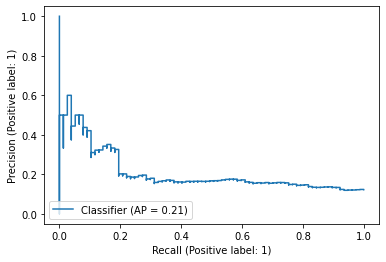

In [34]:
train_using_multivariate(df_mrna_removed, label, list_selected_feature_mrna, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'mRNA',
                         'mrmr')

In [ ]:
train_using_multivariate(df_mrna_removed, label, list_selected_feature_mrna, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'mRNA',
                         'boruta')

# Train cnv

In [ ]:
list_selected_feature_cnv = train_using_mann_whitney(df_cnv_removed, label, 10, 'cnv', 'r_function_with_mannwhitney', 'result_new_experiment/')

In [ ]:
train_using_multivariate(df_cnv_removed, label, list_selected_feature_cnv, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'cnv',
                         'mrmr')

In [ ]:
train_using_multivariate(df_cnv_removed, label, list_selected_feature_cnv, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'cnv',
                         'boruta')

# Train whole dataset

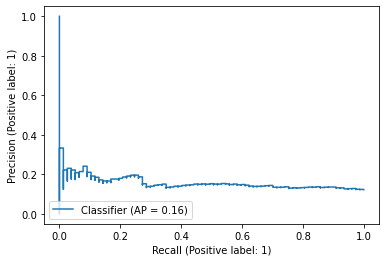

In [33]:
list_selected_feature_concat = train_using_mann_whitney(df_dataset_whole_dataset_removed, label, 10, 'whole_dataset', 'r_function_with_mannwhitney', 'result_new_experiment/')

Running fold : 0it [00:00, ?it/s]

TRAIN:        PHF13     CBWD6    SLC1A4     TCEA2     ACADS     PROX2    WASH7P  \
0    0.064828  0.031579  0.153278  0.095349  0.094453  0.153846  0.341463   
1    0.276453  0.088000  0.254937  0.079274  0.043988  0.115385  0.282759   
2    0.282759  0.092000  0.153743  0.175114  0.143817  0.153846  0.244323   
3    0.000000  0.142737  0.058217  0.040373  0.066105  0.153846  0.154584   
4    0.098916  0.168421  0.080426  0.078415  0.258431  0.000000  0.296047   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.033103  0.065684  0.000395  0.099153  0.056574  0.000000  0.176030   
560  0.224631  0.069053  0.099707  0.178181  0.140274  0.115385  0.617998   
561  0.026010  0.046526  0.054848  0.187262  0.156769  0.000000  0.524390   
562  0.186207  0.047158  0.145937  0.091422  0.137097  0.269231  0.321026   
563  0.125714  0.146947  0.048785  0.115842  0.170821  0.038462  0.322288   

        EFHA1     FCRLA     FCGRT  ...      EMX1     WDR45   APOB48R 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 1it [1:08:56, 4136.92s/it]

TRAIN:        PHF13     CBWD6    SLC1A4     TCEA2     ACADS     PROX2    WASH7P  \
0    0.064828  0.031579  0.153278  0.095349  0.094453  0.153846  0.341463   
1    0.276453  0.088000  0.254937  0.079274  0.043988  0.115385  0.282759   
2    0.000000  0.142737  0.058217  0.040373  0.066105  0.153846  0.154584   
3    0.098916  0.168421  0.080426  0.078415  0.258431  0.000000  0.296047   
4    0.343842  0.025053  0.051526  0.131427  0.120479  0.038462  0.139697   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.344828  0.064632  0.312433  0.088600  0.357649  0.038462  0.441716   
560  0.033103  0.065684  0.000395  0.099153  0.056574  0.000000  0.176030   
561  0.224631  0.069053  0.099707  0.178181  0.140274  0.115385  0.617998   
562  0.186207  0.047158  0.145937  0.091422  0.137097  0.269231  0.321026   
563  0.479606  0.325684  0.095921  0.179899  0.074536  0.307692  0.352902   

        EFHA1     FCRLA     FCGRT  ...    EPS8L2      MEN1     GPKOW 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 2it [2:28:54, 4525.77s/it]

TRAIN:     snoU13|ENSG00000252088.1    SLC1A4     TCEA2     CD109     PROX2  \
0                        -1.0  0.254937  0.079274  0.047846  0.115385   
1                         1.0  0.153743  0.175114  0.043269  0.153846   
2                         0.0  0.058217  0.040373  0.031131  0.153846   
3                         0.0  0.051526  0.131427  0.017753  0.038462   
4                         0.0  0.228244  0.673580  0.021521  0.038462   
..                        ...       ...       ...       ...       ...   
559                       0.0  0.162570  0.058780  0.009888  0.307692   
560                       0.0  0.054848  0.187262  0.006904  0.000000   
561                       0.0  0.145937  0.091422  0.076851  0.269231   
562                       0.0  0.048785  0.115842  0.018031  0.038462   
563                       0.0  0.095921  0.179899  0.054675  0.307692   

       WASH7P     FCGRT    CCDC86     MPPE1    FAM54B  ...    FAM73B  \
0    0.282759  0.039990  0.110593  0.219279  

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 3it [3:13:27, 3679.70s/it]

TRAIN:        PHF13     CBWD6    SLC1A4     TCEA2     BTNL3     PROX2    WASH7P  \
0    0.064828  0.031579  0.153278  0.095349  0.000000  0.153846  0.341463   
1    0.276453  0.088000  0.254937  0.079274  0.000000  0.115385  0.282759   
2    0.282759  0.092000  0.153743  0.175114  0.000000  0.153846  0.244323   
3    0.000000  0.142737  0.058217  0.040373  0.000000  0.153846  0.154584   
4    0.098916  0.168421  0.080426  0.078415  0.102564  0.000000  0.296047   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.224631  0.069053  0.099707  0.178181  0.000000  0.115385  0.617998   
560  0.026010  0.046526  0.054848  0.187262  0.000000  0.000000  0.524390   
561  0.186207  0.047158  0.145937  0.091422  0.000000  0.269231  0.321026   
562  0.125714  0.146947  0.048785  0.115842  0.017094  0.038462  0.322288   
563  0.479606  0.325684  0.095921  0.179899  0.000000  0.307692  0.352902   

        FCRLA     FCGRT  KIAA1267  ...      EMX1     WDR45   C8orf80 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 4it [4:23:36, 3888.40s/it]

TRAIN:       SLC1A4     TCEA2     BTNL3     FCGRT    CCDC86     MPPE1     RGS10  \
0    0.153278  0.095349  0.000000  0.044883  0.232941  0.131785  0.045002   
1    0.254937  0.079274  0.000000  0.039990  0.110593  0.219279  0.080433   
2    0.153743  0.175114  0.000000  0.063167  0.248815  0.256405  0.063339   
3    0.058217  0.040373  0.000000  0.074219  0.075352  0.147851  0.052710   
4    0.080426  0.078415  0.102564  0.132641  0.100228  0.301780  0.016783   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.000395  0.099153  0.000000  0.000000  0.116974  0.104212  0.014731   
560  0.099707  0.178181  0.000000  0.073318  0.107969  0.253148  0.108839   
561  0.054848  0.187262  0.000000  0.092663  0.153677  0.247069  0.119592   
562  0.048785  0.115842  0.017094  0.080298  0.090594  0.194746  0.093051   
563  0.095921  0.179899  0.000000  0.072326  0.731936  0.229700  0.073595   

       FAM54B   SNORA39      WNK4  ...   SNORA21     BTBD6       GP6 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 5it [4:41:41, 2877.56s/it]

TRAIN:        PHF13     CBWD6     TCEA2     BTNL3     PROX2      PKP3    WASH7P  \
0    0.064828  0.031579  0.095349  0.000000  0.153846  0.145336  0.341463   
1    0.282759  0.092000  0.175114  0.000000  0.153846  0.149522  0.244323   
2    0.000000  0.142737  0.040373  0.000000  0.153846  0.071584  0.154584   
3    0.098916  0.168421  0.078415  0.102564  0.000000  0.292157  0.296047   
4    0.343842  0.025053  0.131427  0.000000  0.038462  0.095939  0.139697   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.224631  0.069053  0.178181  0.000000  0.115385  0.116794  0.617998   
560  0.026010  0.046526  0.187262  0.000000  0.000000  0.156829  0.524390   
561  0.186207  0.047158  0.091422  0.000000  0.269231  0.156449  0.321026   
562  0.125714  0.146947  0.115842  0.017094  0.038462  0.132473  0.322288   
563  0.479606  0.325684  0.179899  0.000000  0.307692  0.313164  0.352902   

        FCRLA     FCGRT  C14orf169  ...     CISD3       GP6      EMX1

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 6it [5:15:12, 2582.87s/it]

TRAIN:        PHF13    SLC1A4     TCEA2     ACADS     PROX2    WASH7P     FCRLA  \
0    0.064828  0.153278  0.095349  0.094453  0.153846  0.341463  0.011666   
1    0.276453  0.254937  0.079274  0.043988  0.115385  0.282759  0.004537   
2    0.282759  0.153743  0.175114  0.143817  0.153846  0.244323  0.003456   
3    0.000000  0.058217  0.040373  0.066105  0.153846  0.154584  0.010585   
4    0.098916  0.080426  0.078415  0.258431  0.000000  0.296047  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.224631  0.099707  0.178181  0.140274  0.115385  0.617998  0.000864   
560  0.026010  0.054848  0.187262  0.156769  0.000000  0.524390  0.051631   
561  0.186207  0.145937  0.091422  0.137097  0.269231  0.321026  0.104558   
562  0.125714  0.048785  0.115842  0.170821  0.038462  0.322288  0.023331   
563  0.479606  0.095921  0.179899  0.074536  0.307692  0.352902  0.001728   

        FCGRT  C14orf169    GABRB1  ...     PGAM2      EMX1     WDR45

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 7it [5:56:10, 2542.32s/it]

TRAIN:       MTMR9L     PHF13    SLC1A4     TCEA2     BTNL3    WASH7P     FCRLA  \
0    0.147788  0.064828  0.153278  0.095349  0.000000  0.341463  0.011666   
1    0.128319  0.276453  0.254937  0.079274  0.000000  0.282759  0.004537   
2    0.232743  0.282759  0.153743  0.175114  0.000000  0.244323  0.003456   
3    0.195575  0.098916  0.080426  0.078415  0.102564  0.296047  0.000000   
4    0.040708  0.343842  0.051526  0.131427  0.000000  0.139697  0.019011   
..        ...       ...       ...       ...       ...       ...       ...   
560  0.679646  0.224631  0.099707  0.178181  0.000000  0.617998  0.000864   
561  0.155752  0.026010  0.054848  0.187262  0.000000  0.524390  0.051631   
562  0.361062  0.186207  0.145937  0.091422  0.000000  0.321026  0.104558   
563  0.562832  0.125714  0.048785  0.115842  0.017094  0.322288  0.023331   
564  0.391150  0.479606  0.095921  0.179899  0.000000  0.352902  0.001728   

        FCGRT  C14orf169    CCDC86  ...      EMX1     WDR45   APOB48R

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 8it [6:56:25, 2883.54s/it]

TRAIN:        PHF13    SLC1A4     BTNL3    WASH7P     FCRLA     FCGRT  C14orf169  \
0    0.064828  0.153278  0.000000  0.341463  0.011666  0.044883   0.099321   
1    0.276453  0.254937  0.000000  0.282759  0.004537  0.039990   0.290253   
2    0.282759  0.153743  0.000000  0.244323  0.003456  0.063167   0.169340   
3    0.000000  0.058217  0.000000  0.154584  0.010585  0.074219   0.104257   
4    0.098916  0.080426  0.102564  0.296047  0.000000  0.132641   0.177977   
..        ...       ...       ...       ...       ...       ...        ...   
560  0.224631  0.099707  0.000000  0.617998  0.000864  0.073318   0.141579   
561  0.026010  0.054848  0.000000  0.524390  0.051631  0.092663   0.045959   
562  0.186207  0.145937  0.000000  0.321026  0.104558  0.093894   0.132943   
563  0.125714  0.048785  0.017094  0.322288  0.023331  0.080298   0.156385   
564  0.479606  0.095921  0.000000  0.352902  0.001728  0.072326   0.681678   

       CCDC86     MPPE1     RGS10  ...    CCDC84     BTBD

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Running fold : 9it [7:24:09, 2502.36s/it]

TRAIN:       SLC1A4     BTNL3     PROX2    WASH7P     FCGRT    CCDC86     MPPE1  \
0    0.153278  0.000000  0.153846  0.341463  0.044883  0.232941  0.131785   
1    0.254937  0.000000  0.115385  0.282759  0.039990  0.110593  0.219279   
2    0.153743  0.000000  0.153846  0.244323  0.063167  0.248815  0.256405   
3    0.058217  0.000000  0.153846  0.154584  0.074219  0.075352  0.147851   
4    0.080426  0.102564  0.000000  0.296047  0.132641  0.100228  0.301780   
..        ...       ...       ...       ...       ...       ...       ...   
560  0.099707  0.000000  0.115385  0.617998  0.073318  0.107969  0.253148   
561  0.054848  0.000000  0.000000  0.524390  0.092663  0.153677  0.247069   
562  0.145937  0.000000  0.269231  0.321026  0.093894  0.086475  0.264221   
563  0.048785  0.017094  0.038462  0.322288  0.080298  0.090594  0.194746   
564  0.095921  0.000000  0.307692  0.352902  0.072326  0.731936  0.229700   

       FAM54B   SNORA39      IRF5  ...    VPS37D    MRPL16   KLHDC7B 

/home/ale/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{1: ['ZFP82',
  'TIMM10B',
  'EIF4A3',
  'FLJ40330',
  'ZNF383',
  'SENP3',
  'WDSUB1',
  'HIST1H2AC',
  'MUL1',
  'DDIT3',
  'CLCN6',
  'INPP5K',
  'PRX',
  'OPHN1',
  'STAG3L3',
  'LOC284009',
  'LRRK1',
  'HTR1D',
  'TRAPPC3',
  'PMS2L11',
  'DNAJB9',
  'MIS12',
  'MED31',
  'FAM76A',
  'DNAJC7',
  'TDRD5',
  'BET1',
  'SESN2',
  'PPP1R8',
  'C7orf64',
  'C18orf8',
  'TBC1D22B',
  'RINL',
  'SRRM1',
  'C20orf111',
  'NECAP2',
  'POLR2J4',
  'hsa-mir-662',
  'NT5DC3',
  'B4GALT4',
  'IL28RA',
  'SFRS17A',
  'HSPC159',
  'LIN37',
  'RPIA',
  'MFF',
  'C1orf128',
  'C17orf100',
  'PSPC1',
  'L3MBTL2',
  'C17orf39',
  'ARIH2',
  'COPS3',
  'LOC285830',
  'CAMK1D',
  'USP48',
  'FBXO42',
  'NUMBL',
  'PPM1B',
  'RNF185',
  'ZFP3',
  'DLX6',
  'GOSR2',
  'VAPA',
  'CWF19L2',
  'MSTO2P',
  'ZSWIM7',
  'SPTBN4',
  'ZNF280B',
  'TMCO4',
  'RAE1',
  'DHRS11',
  'RRAGB',
  'CCT6P1',
  'IQCB1',
  'FXR2',
  'DOM3Z',
  'LOC220594',
  'TRIM39',
  'CCNB3',
  'ZNF398',
  'C6orf132',
  'LRRC37B',
  '

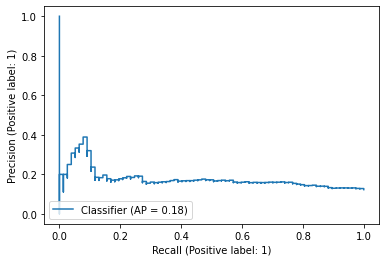

In [34]:
train_using_multivariate(df_dataset_whole_dataset_removed, label, list_selected_feature_concat, 10,
                         'r_function_with_mannwhitney_mrmr/', 
                         'result_new_experiment/',
                         'whole_dataset',
                         'mrmr')

Running fold : 0it [00:00, ?it/s]

TRAIN:        PHF13     CBWD6    SLC1A4     TCEA2     ACADS     PROX2    WASH7P  \
0    0.064828  0.031579  0.153278  0.095349  0.094453  0.153846  0.341463   
1    0.276453  0.088000  0.254937  0.079274  0.043988  0.115385  0.282759   
2    0.282759  0.092000  0.153743  0.175114  0.143817  0.153846  0.244323   
3    0.000000  0.142737  0.058217  0.040373  0.066105  0.153846  0.154584   
4    0.098916  0.168421  0.080426  0.078415  0.258431  0.000000  0.296047   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.033103  0.065684  0.000395  0.099153  0.056574  0.000000  0.176030   
560  0.224631  0.069053  0.099707  0.178181  0.140274  0.115385  0.617998   
561  0.026010  0.046526  0.054848  0.187262  0.156769  0.000000  0.524390   
562  0.186207  0.047158  0.145937  0.091422  0.137097  0.269231  0.321026   
563  0.125714  0.146947  0.048785  0.115842  0.170821  0.038462  0.322288   

        EFHA1     FCRLA     FCGRT  ...      EMX1     WDR45   APOB48R 

Running fold : 1it [00:17, 17.58s/it]

TRAIN:        PHF13     CBWD6    SLC1A4     TCEA2     ACADS     PROX2    WASH7P  \
0    0.064828  0.031579  0.153278  0.095349  0.094453  0.153846  0.341463   
1    0.276453  0.088000  0.254937  0.079274  0.043988  0.115385  0.282759   
2    0.000000  0.142737  0.058217  0.040373  0.066105  0.153846  0.154584   
3    0.098916  0.168421  0.080426  0.078415  0.258431  0.000000  0.296047   
4    0.343842  0.025053  0.051526  0.131427  0.120479  0.038462  0.139697   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.344828  0.064632  0.312433  0.088600  0.357649  0.038462  0.441716   
560  0.033103  0.065684  0.000395  0.099153  0.056574  0.000000  0.176030   
561  0.224631  0.069053  0.099707  0.178181  0.140274  0.115385  0.617998   
562  0.186207  0.047158  0.145937  0.091422  0.137097  0.269231  0.321026   
563  0.479606  0.325684  0.095921  0.179899  0.074536  0.307692  0.352902   

        EFHA1     FCRLA     FCGRT  ...    EPS8L2      MEN1     GPKOW 

Running fold : 2it [00:42, 21.80s/it]

TRAIN:     snoU13|ENSG00000252088.1    SLC1A4     TCEA2     CD109     PROX2  \
0                        -1.0  0.254937  0.079274  0.047846  0.115385   
1                         1.0  0.153743  0.175114  0.043269  0.153846   
2                         0.0  0.058217  0.040373  0.031131  0.153846   
3                         0.0  0.051526  0.131427  0.017753  0.038462   
4                         0.0  0.228244  0.673580  0.021521  0.038462   
..                        ...       ...       ...       ...       ...   
559                       0.0  0.162570  0.058780  0.009888  0.307692   
560                       0.0  0.054848  0.187262  0.006904  0.000000   
561                       0.0  0.145937  0.091422  0.076851  0.269231   
562                       0.0  0.048785  0.115842  0.018031  0.038462   
563                       0.0  0.095921  0.179899  0.054675  0.307692   

       WASH7P     FCGRT    CCDC86     MPPE1    FAM54B  ...    FAM73B  \
0    0.282759  0.039990  0.110593  0.219279  

Running fold : 3it [01:02, 21.18s/it]

TRAIN:        PHF13     CBWD6    SLC1A4     TCEA2     BTNL3     PROX2    WASH7P  \
0    0.064828  0.031579  0.153278  0.095349  0.000000  0.153846  0.341463   
1    0.276453  0.088000  0.254937  0.079274  0.000000  0.115385  0.282759   
2    0.282759  0.092000  0.153743  0.175114  0.000000  0.153846  0.244323   
3    0.000000  0.142737  0.058217  0.040373  0.000000  0.153846  0.154584   
4    0.098916  0.168421  0.080426  0.078415  0.102564  0.000000  0.296047   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.224631  0.069053  0.099707  0.178181  0.000000  0.115385  0.617998   
560  0.026010  0.046526  0.054848  0.187262  0.000000  0.000000  0.524390   
561  0.186207  0.047158  0.145937  0.091422  0.000000  0.269231  0.321026   
562  0.125714  0.146947  0.048785  0.115842  0.017094  0.038462  0.322288   
563  0.479606  0.325684  0.095921  0.179899  0.000000  0.307692  0.352902   

        FCRLA     FCGRT  KIAA1267  ...      EMX1     WDR45   C8orf80 

Running fold : 4it [01:24, 21.37s/it]

TRAIN:       SLC1A4     TCEA2     BTNL3     FCGRT    CCDC86     MPPE1     RGS10  \
0    0.153278  0.095349  0.000000  0.044883  0.232941  0.131785  0.045002   
1    0.254937  0.079274  0.000000  0.039990  0.110593  0.219279  0.080433   
2    0.153743  0.175114  0.000000  0.063167  0.248815  0.256405  0.063339   
3    0.058217  0.040373  0.000000  0.074219  0.075352  0.147851  0.052710   
4    0.080426  0.078415  0.102564  0.132641  0.100228  0.301780  0.016783   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.000395  0.099153  0.000000  0.000000  0.116974  0.104212  0.014731   
560  0.099707  0.178181  0.000000  0.073318  0.107969  0.253148  0.108839   
561  0.054848  0.187262  0.000000  0.092663  0.153677  0.247069  0.119592   
562  0.048785  0.115842  0.017094  0.080298  0.090594  0.194746  0.093051   
563  0.095921  0.179899  0.000000  0.072326  0.731936  0.229700  0.073595   

       FAM54B   SNORA39      WNK4  ...   SNORA21     BTBD6       GP6 

Running fold : 5it [01:43, 20.36s/it]

TRAIN:        PHF13     CBWD6     TCEA2     BTNL3     PROX2      PKP3    WASH7P  \
0    0.064828  0.031579  0.095349  0.000000  0.153846  0.145336  0.341463   
1    0.282759  0.092000  0.175114  0.000000  0.153846  0.149522  0.244323   
2    0.000000  0.142737  0.040373  0.000000  0.153846  0.071584  0.154584   
3    0.098916  0.168421  0.078415  0.102564  0.000000  0.292157  0.296047   
4    0.343842  0.025053  0.131427  0.000000  0.038462  0.095939  0.139697   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.224631  0.069053  0.178181  0.000000  0.115385  0.116794  0.617998   
560  0.026010  0.046526  0.187262  0.000000  0.000000  0.156829  0.524390   
561  0.186207  0.047158  0.091422  0.000000  0.269231  0.156449  0.321026   
562  0.125714  0.146947  0.115842  0.017094  0.038462  0.132473  0.322288   
563  0.479606  0.325684  0.179899  0.000000  0.307692  0.313164  0.352902   

        FCRLA     FCGRT  C14orf169  ...     CISD3       GP6      EMX1

Running fold : 6it [02:05, 20.99s/it]

TRAIN:        PHF13    SLC1A4     TCEA2     ACADS     PROX2    WASH7P     FCRLA  \
0    0.064828  0.153278  0.095349  0.094453  0.153846  0.341463  0.011666   
1    0.276453  0.254937  0.079274  0.043988  0.115385  0.282759  0.004537   
2    0.282759  0.153743  0.175114  0.143817  0.153846  0.244323  0.003456   
3    0.000000  0.058217  0.040373  0.066105  0.153846  0.154584  0.010585   
4    0.098916  0.080426  0.078415  0.258431  0.000000  0.296047  0.000000   
..        ...       ...       ...       ...       ...       ...       ...   
559  0.224631  0.099707  0.178181  0.140274  0.115385  0.617998  0.000864   
560  0.026010  0.054848  0.187262  0.156769  0.000000  0.524390  0.051631   
561  0.186207  0.145937  0.091422  0.137097  0.269231  0.321026  0.104558   
562  0.125714  0.048785  0.115842  0.170821  0.038462  0.322288  0.023331   
563  0.479606  0.095921  0.179899  0.074536  0.307692  0.352902  0.001728   

        FCGRT  C14orf169    GABRB1  ...     PGAM2      EMX1     WDR45

Running fold : 7it [02:29, 22.02s/it]

TRAIN:       MTMR9L     PHF13    SLC1A4     TCEA2     BTNL3    WASH7P     FCRLA  \
0    0.147788  0.064828  0.153278  0.095349  0.000000  0.341463  0.011666   
1    0.128319  0.276453  0.254937  0.079274  0.000000  0.282759  0.004537   
2    0.232743  0.282759  0.153743  0.175114  0.000000  0.244323  0.003456   
3    0.195575  0.098916  0.080426  0.078415  0.102564  0.296047  0.000000   
4    0.040708  0.343842  0.051526  0.131427  0.000000  0.139697  0.019011   
..        ...       ...       ...       ...       ...       ...       ...   
560  0.679646  0.224631  0.099707  0.178181  0.000000  0.617998  0.000864   
561  0.155752  0.026010  0.054848  0.187262  0.000000  0.524390  0.051631   
562  0.361062  0.186207  0.145937  0.091422  0.000000  0.321026  0.104558   
563  0.562832  0.125714  0.048785  0.115842  0.017094  0.322288  0.023331   
564  0.391150  0.479606  0.095921  0.179899  0.000000  0.352902  0.001728   

        FCGRT  C14orf169    CCDC86  ...      EMX1     WDR45   APOB48R

Running fold : 8it [02:48, 21.11s/it]

TRAIN:        PHF13    SLC1A4     BTNL3    WASH7P     FCRLA     FCGRT  C14orf169  \
0    0.064828  0.153278  0.000000  0.341463  0.011666  0.044883   0.099321   
1    0.276453  0.254937  0.000000  0.282759  0.004537  0.039990   0.290253   
2    0.282759  0.153743  0.000000  0.244323  0.003456  0.063167   0.169340   
3    0.000000  0.058217  0.000000  0.154584  0.010585  0.074219   0.104257   
4    0.098916  0.080426  0.102564  0.296047  0.000000  0.132641   0.177977   
..        ...       ...       ...       ...       ...       ...        ...   
560  0.224631  0.099707  0.000000  0.617998  0.000864  0.073318   0.141579   
561  0.026010  0.054848  0.000000  0.524390  0.051631  0.092663   0.045959   
562  0.186207  0.145937  0.000000  0.321026  0.104558  0.093894   0.132943   
563  0.125714  0.048785  0.017094  0.322288  0.023331  0.080298   0.156385   
564  0.479606  0.095921  0.000000  0.352902  0.001728  0.072326   0.681678   

       CCDC86     MPPE1     RGS10  ...    CCDC84     BTBD

Running fold : 9it [03:08, 20.60s/it]

TRAIN:       SLC1A4     BTNL3     PROX2    WASH7P     FCGRT    CCDC86     MPPE1  \
0    0.153278  0.000000  0.153846  0.341463  0.044883  0.232941  0.131785   
1    0.254937  0.000000  0.115385  0.282759  0.039990  0.110593  0.219279   
2    0.153743  0.000000  0.153846  0.244323  0.063167  0.248815  0.256405   
3    0.058217  0.000000  0.153846  0.154584  0.074219  0.075352  0.147851   
4    0.080426  0.102564  0.000000  0.296047  0.132641  0.100228  0.301780   
..        ...       ...       ...       ...       ...       ...       ...   
560  0.099707  0.000000  0.115385  0.617998  0.073318  0.107969  0.253148   
561  0.054848  0.000000  0.000000  0.524390  0.092663  0.153677  0.247069   
562  0.145937  0.000000  0.269231  0.321026  0.093894  0.086475  0.264221   
563  0.048785  0.017094  0.038462  0.322288  0.080298  0.090594  0.194746   
564  0.095921  0.000000  0.307692  0.352902  0.072326  0.731936  0.229700   

       FAM54B   SNORA39      IRF5  ...    VPS37D    MRPL16   KLHDC7B 

{1: ['TMEM156',
  'SRRM5',
  'TTC36',
  'RTP4',
  'FLJ40330',
  'PRSS45',
  'ATAD3C',
  'BCAS4',
  'PABPC1L',
  'LOC96610',
  'ITM2C',
  'p27',
  'CXCL16'],
 2: ['C6orf226',
  'LRIG1',
  'FBF1',
  'SRRM5',
  'TTC36',
  'PRSS45',
  'ATAD3C',
  'LOC648740',
  'BCAS4',
  'PABPC1L',
  'SNX15',
  'HIST1H2AE',
  'C1orf213',
  'LOC284009',
  'MARVELD3',
  'AFG3L1'],
 3: ['TMEM156',
  'FBF1',
  'SRRM5',
  'TTC36',
  'LOC100130015',
  'FLJ40330',
  'PABPC1L',
  'ANGPTL6',
  'LOC284009',
  'AFG3L1'],
 4: ['C6orf226',
  'FN3K',
  'TTC36',
  'LOC100130015',
  'FLJ40330',
  'SPR',
  'Akt_pS473',
  'ACSF2',
  'PABPC1L',
  'SNX15',
  'C3orf62',
  'SAMD10',
  'SPTBN4',
  'mTOR',
  'ANGPTL6',
  'LOC284009'],
 5: ['C6orf226',
  'C8orf77',
  'SRRM5',
  'TTC36',
  'FLJ40330',
  'LOC100287227',
  'ACSF2',
  'BCAS4',
  'PABPC1L',
  'C17orf47',
  'SNX15',
  'VEGFB',
  'FAM164C',
  'ANGPTL6',
  'LOC284009',
  'GP6'],
 6: ['TMEM156',
  'MED19',
  'hsa-mir-155',
  'SRRM5',
  'BSCL2',
  'KIF9',
  'hsa-mir-142',


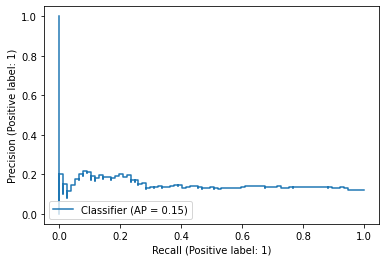

In [35]:
train_using_multivariate(df_dataset_whole_dataset_removed, label, list_selected_feature_concat, 10,
                         'r_function_with_mannwhitney_boruta/', 
                         'result_new_experiment/',
                         'whole_dataset',
                         'boruta')

# Train on whole dataset with: 1) mannwthineyu, 2) mannwthineyu + boruta and mannwthineyu + mrmr 

# Prepare data mannwhitney

In [26]:
proteins_selected_features = mann_whitney_features_selection(df_proteins_removed, label, 0.05)
proteins_mannwhitney = df_proteins_removed[proteins_selected_features]

Index(['PRAS40_pT246', 'GSK3_pS9', 'Raptor', 'mTOR', 'FASN', 'A-Raf', 'p27',
       'Jak2', 'PREX1', 'Shc_pY317', 'p38_pT180_Y182', 'XRCC1', 'Akt_pS473',
       'Ku80', 'Bcl-2'],
      dtype='object')

In [ ]:
cnv_selected_features = mann_whitney_features_selection(df_cnv_removed, label, 0.05)
cnv_mannwhitney = df_cnv_removed[cnv_selected_features]

In [ ]:
mirna_selected_features = mann_whitney_features_selection(df_mirna_removed, label, 0.05)
mirna_mannwhitney = df_mirna_removed[mirna_selected_features]

In [ ]:
mrna_selected_features = mann_whitney_features_selection(df_mrna_removed, label, 0.05)
mrna_mannwhitney = df_mrna_removed[mrna_selected_features]

In [ ]:
whole_dataset_selected_features = mann_whitney_features_selection(df_dataset_whole_dataset_removed, label, 0.05)
whole_mannwhitney = df_dataset_whole_dataset_removed[whole_dataset_selected_features]

In [ ]:
dataset_proteins_mirna_selected_features = mann_whitney_features_selection(df_dataset_proteins_mirna_removed,
                                                                             label, 0.05)
dataset_proteins_mirna_mannwhitney = df_dataset_proteins_mirna_removed [dataset_proteins_mirna_selected_features]

In [ ]:
dataset_proteins_mirna_mrna_selected_features = mann_whitney_features_selection(df_dataset_proteins_mirna_mrna_removed,
                                                                               label, 0.05)

dataset_proteins_mirna_mrna_mannwhitney = df_dataset_proteins_mirna_mrna_removed[dataset_proteins_mirna_mrna_selected_features]

# Prepare data Boruta

In [28]:
proteins_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(proteins_mannwhitney, label, 5)

In [29]:
cnv_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(cnv_mannwhitney, label, 5)

['PRAS40_pT246', 'mTOR', 'p27', 'Jak2']

In [30]:
mirna_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(mirna_mannwhitney, label, 5)

,PRAS40_pT246,mTOR,p27,Jak2
0,0.617066,0.492546,0.218901,0.661667
1,0.495525,0.719286,0.442895,0.594790
2,0.477525,0.726308,0.288495,0.610465
3,0.619577,0.696904,0.416031,0.638760
4,0.436008,0.732141,0.193335,0.608172
...,...,...,...,...
622,0.598971,0.292064,0.489697,0.564028
623,0.358247,0.786068,0.433030,0.682370
624,0.425565,0.653618,0.274580,0.535525
625,0.453955,0.718558,0.200432,0.466529


In [ ]:
mrna_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(mrna_mannwhitney, label, 5)

In [ ]:
whole_dataset_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(whole_mannwhitney, label, 5)

In [ ]:
dataset_proteins_mirna_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(dataset_proteins_mirna_mannwhitney, label, 5)

In [ ]:
dataset_proteins_mirna_mrna_selected_features_boruta, discarded_feature =  execute_boruta_feature_selection(dataset_proteins_mirna_mrna_mannwhitney, label, 5)

# Training function

In [32]:
def train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(X, label, num_external_fold,
                                          type_dataset, tecnique_feature_selection,
                                          path):
    
    """
    X : data using number of features of intrinsic dimensionality and appliying umap features extraction.
    """
    
    aucs = []
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}   
    iterator = 1
    
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_fold, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_fold)[:, 1]
        
        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y_test_fold, y_score)

        #plot_precision_recall_curve(classifier, X_test_selected_feature, y_test_fold)
        
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        # Use AUC function to calculate the area under the curve of precision recall curve
        auc_precision_recall = auc(recall, precision)
        
        aucs.append(auc_precision_recall)
        #print('auc: {:.3f} using params {}:'.format(auc_precision_recall, clf.best_params_))
    
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score)
        plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+str(iterator)+'_AUPRC_Internal.pdf')
        iterator = iterator+1
        
    internal_auc = np.mean(aucs)
    
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test_fold_concatenated, y_score_concatenated)
    
    external_auc = auc(recall, precision)
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated)
    #plt.show()
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_auc)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_auc)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    
    plt.savefig(path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open(path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return '{0:.4f}'.format(internal_auc), '{0:.4f}'.format(external_auc), clf.best_estimator_

# Training only with mannwhitney feature selection

('0.2223',
 '0.1865',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=2, n_estimators=101))

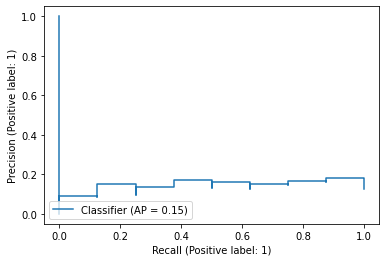

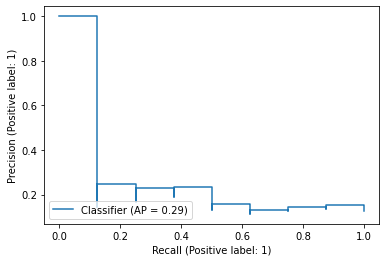

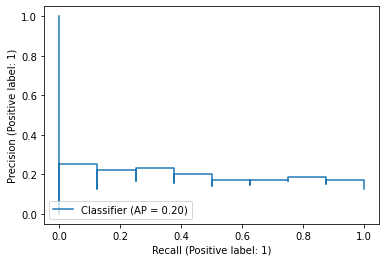

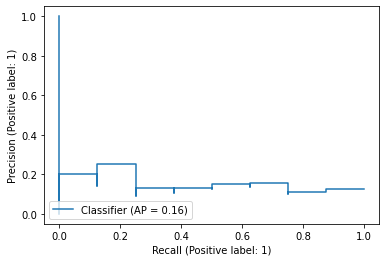

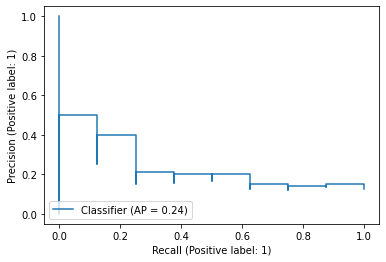

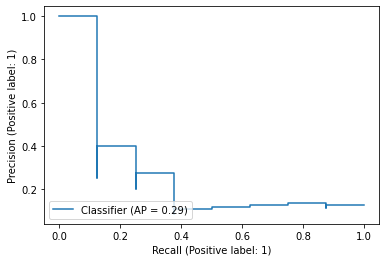

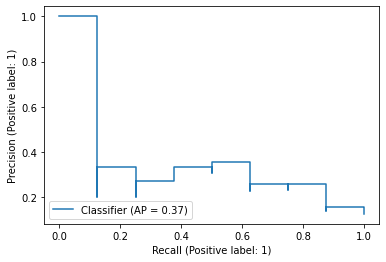

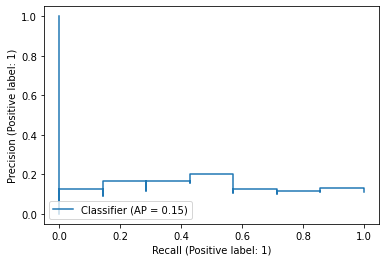

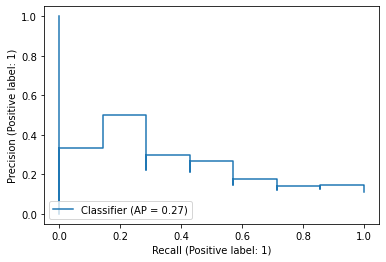

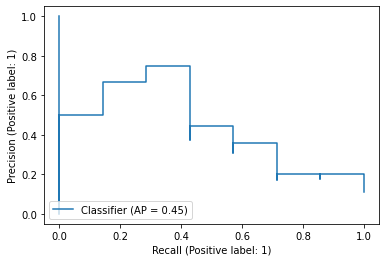

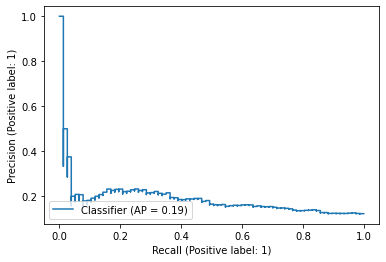

In [37]:
!mkdir 'result_Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset'
!mkdir 'result_Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/r_function_mannwhtiney'
train_using_mannwhitney_and_boruta_or_mrmr_whole_dataset(df_proteins_removed[proteins_selected_features].to_numpy(), label, 10, 'proteins', 'r_function_mannwhtiney', 'result_Experiments_using_R_Function_mannwhitney_and_multivariate_feature_selection_whole_dataset/')